In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import binomtest, mannwhitneyu

In [55]:
likes = pd.read_csv('likes.csv')
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [3]:
# пропущенных значений нет
# данные о лайках юзеров (когда, кем и какой пост лайкнут)
likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230176 entries, 0 to 230175
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    230176 non-null  int64
 1   post_id    230176 non-null  int64
 2   timestamp  230176 non-null  int64
dtypes: int64(3)
memory usage: 5.3 MB


In [4]:
likes.user_id.nunique(), likes.post_id.nunique()

(58171, 6831)

<AxesSubplot:>

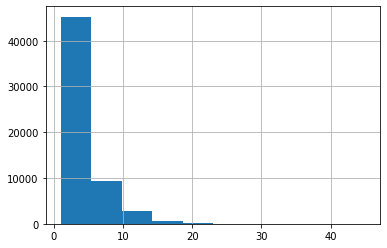

In [5]:
# число лайков на юзера - логнорм распределение
likes_for_users = likes.groupby('user_id', as_index = False).agg({'post_id' : 'count'}).rename(columns = {'post_id' : 'likes_count'})
likes_for_users.likes_count.hist()

In [56]:
# данные о просмотрах
views = pd.read_csv('views.csv')
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [9]:
# без пропущенных значений
# данные о просмотрах рекомендаций юзерами из разных тестовых групп
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193295 entries, 0 to 193294
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          193295 non-null  int64 
 1   exp_group        193295 non-null  object
 2   recommendations  193295 non-null  object
 3   timestamp        193295 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.9+ MB


In [10]:
views.user_id.nunique()

65013

In [57]:
# группы примерно равны
views.exp_group.value_counts(normalize = True)

test       0.501394
control    0.498606
Name: exp_group, dtype: float64

Проверим систему сплитования на всякий случай (нет ли юзеров, попавших в обе группы), и если вдруг есть:  
    - удалим их из обеих групп в случае незначительного количества,  
    - пойдем смотреть систему сплитования в случае большого числа задвоенных пользователей

In [58]:
# ищем повторных
duplicates_users = ((views[['user_id', 'exp_group']] \
  .drop_duplicates()) \
 .groupby('user_id', as_index = False) \
 .agg({'exp_group' : 'count'}) \
 .sort_values(by = 'exp_group', ascending = False) \
 .query('exp_group > 1').user_id).tolist()
duplicates_users

[142283, 148670, 55788, 25623]

In [59]:
# удаляем найденных юзеров из обеих групп
def cut_duplicates(df, lst):
    for i in range(len(lst)):
        df = df.query('user_id != @lst[@i]')
    return df

likes_cut = cut_duplicates(likes, duplicates_users)
views_cut = cut_duplicates(views, duplicates_users)

In [60]:
views_cut.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

Как будто группы примерно равны, но проверим дополнительно биномиальным тестом

In [10]:
# нет оснований отклонить гипотезу об отсутствии различий между группами
binomtest(32659, 65009, p=0.5)

BinomTestResult(k=32659, n=65009, alternative='two-sided', proportion_estimate=0.5023765940100602, pvalue=0.2270501563614752)

Группы теста и контроля почти равны по числу юзеров, но различается ли поведение пользователей в группах?  
Сравним тест и контроль по тому, как они оценивали рекомендованные посты (*число лайков в группе / hitrate*)

In [61]:
# табличка с группами юзеров
users_group = views_cut[['user_id', 'exp_group']].drop_duplicates()

# примерджим юзерам и группам их лайки
users_group_like = users_group.merge(likes_for_users, how = 'left').fillna(0)

# добавим колонку с фактом лайка показанной рекомендации для удобства
users_group_like['is_like'] = np.where(users_group_like.likes_count != 0, 1, 0)

In [62]:
# посмотрим на средние метрики по группам
users_group_like.groupby('exp_group', as_index = False)[['likes_count', 'is_like']].mean()

,exp_group,likes_count,is_like
0,control,3.487079,0.891314
1,test,3.592578,0.898160


In [63]:
# число лайков в группе проверим критерием Манна-Уитни, поскольку лайки распределены логнормально
# видно, что различия стат значимы при уровне значимости 0,05
mannwhitneyu(
    users_group_like[users_group_like.exp_group == 'test'].likes_count,
    users_group_like[users_group_like.exp_group == 'control'].likes_count)

MannwhitneyuResult(statistic=538160577.0, pvalue=2.9585062792441964e-05)

### Высчитаем общий hitrate (доля рекомендаций, в которые пользователи кликнули)  
Основная идея - распилим список рекомендаций по рекомендованным постам, примерджим к полученным данным лайки по айдишникам юзера и поста. Так мы увидим, было ли просмотрено что - то из рекомендованного каждым юзером и время просмотра. Ну и исходя из этого оценим метрику

In [64]:
views_cut['post_id'] = views_cut.recommendations.apply(lambda x: x[1:-1].split(' '))
views_cut = views_cut.explode('post_id')
views_cut = views_cut[views_cut.post_id != '']
views_cut.post_id = views_cut.post_id.map(int)
full_likes_views = views_cut.merge(likes_cut, how = 'left', on = ['user_id', 'post_id'])

In [65]:
# итоговая таблица с активностями сильно выросла
full_likes_views.shape

(966573, 6)

In [66]:
# общее число просмотров рекомендаций
full_likes_views.recommendations.nunique()

193268

In [67]:
# таблица с активностями, у которых зафиксировано время рекомендации и лайка соответствующих постов
with_likes = full_likes_views[full_likes_views.timestamp_y.notna()]

In [68]:
# почти 231 тысячу ранее рекомендованных постов лайкнули юзеры
with_likes.shape

(230996, 6)

In [144]:
# а это все показы рекомендаций, которые имеют лайки
with_likes.recommendations.nunique()

138066

In [141]:
# доля показов рекомендаций, где был хоть один лайк
# hitrate
138066/193268

0.7143758925429973

### Отличаются ли метрики тестовых групп между собой и значимо ли это различие?  
Применим бакетный подход на 100 бакетов, чтобы посчитать групповой hitrate (доля hitrate по группе/бакету). Уровень значимости останется тем же на уровне 0.05.

In [217]:
full_likes_views_bucket = full_likes_views.copy()
full_likes_views_bucket.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,3644,NaN
1,128381,control,[3644 4529 4704 5294 4808],1654030803,4529,NaN
2,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1.654031e+09
3,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1.654031e+09
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4808,NaN


In [218]:
# добавим лайки юзеров
full_likes_views_bucket['likes'] = np.where(full_likes_views_bucket.timestamp_y == full_likes_views_bucket.timestamp_y, 1,0)
full_likes_views_bucket.drop(columns = 'timestamp_y',axis = 1, inplace = True)
full_likes_views_bucket.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,likes
0,128381,control,[3644 4529 4704 5294 4808],1654030803,3644,0
1,128381,control,[3644 4529 4704 5294 4808],1654030803,4529,0
2,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1
3,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4808,0


In [219]:
# подготовим бакеты
import hashlib

full_likes_views_bucket['bucket'] = full_likes_views_bucket['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'bbb').encode()).hexdigest(), 16) % 100
)

In [220]:
# посчитаем лайки и просмотры по каждой рекомендации
buckets = full_likes_views_bucket.groupby(['exp_group', 'bucket', 'recommendations'], as_index = False).sum('likes')
buckets.likes = np.where(buckets.likes == 0, 0, 1)
buckets['view'] = 1
buckets.head()

,exp_group,bucket,recommendations,user_id,timestamp_x,post_id,likes,view
0,control,0,[ 3 4395 7231 1846 4653],706345,8271085790,18128,0,1
1,control,0,[ 3 6141 2731 34 6702],518135,8271444070,15611,1,1
2,control,0,[ 15 2858 1602 1026 6482],395885,8274989660,11983,1,1
3,control,0,[ 43 1277 6110 1743 1311],375540,8275896595,10484,1,1
4,control,0,[ 46 6572 7307 131 1465],720855,8270863090,15521,1,1


In [221]:
# сгруппируем по бакетам тестовых групп и посчитаем метрики для каждого бакета
buckets_res = buckets.groupby(['exp_group', 'bucket'], as_index = False).sum(['likes', 'views'])
buckets_res['bucket_hitrate'] = buckets_res.likes / buckets_res.view
buckets_res.groupby('exp_group').bucket_hitrate.mean()

exp_group
control    0.707695
test       0.720972
Name: bucket_hitrate, dtype: float64

Видно, что в тесте метрика увеличилась на 2пп, необходимо проверить значимость изменений (используем все так же Манна - Уитни)

In [224]:
# рассмотренные распределения различаются значимо
# hitrate в тестовой группе вырос
mannwhitneyu(buckets_res[buckets_res.exp_group == 'test'].bucket_hitrate, buckets_res[buckets_res.exp_group == 'control'].bucket_hitrate)

MannwhitneyuResult(statistic=7548.0, pvalue=4.829847062588435e-10)